See how to use Shor's algorithm to factor 15 here:    <b><a href="https://portal.quantumrings.com/doc/Shors.html">Shor15</a></b>

<i><b>Source code to factorize 15</b></i>

Note: Be sure to use your API token and your account name.

Step 1. Import the required modules and obtain the backend

In [1]:
import QuantumRingsLib
from QuantumRingsLib import QuantumRegister, AncillaRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor
from QuantumRingsLib import JobStatus
from matplotlib import pyplot as plt
import numpy as np
import math
import random

provider = QuantumRingsProvider(
    token=<TOKEN>,
    name=<NAME>
)
backend = provider.get_backend("scarlet_quantum_rings")
shots = 1024

provider.active_account()

{'name': <NAME>,
 'token': <TOKEN> ,
 'max_qubits': '200'}

In [2]:
Step 2. Define the core methods

SyntaxError: invalid syntax (1952229193.py, line 1)

In [8]:
def iqft_cct(qc, b, n):
    """
    The inverse QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cu1(  -math.pi / 2** ( i -j + 1 ), b[j - 1], b[i])
        # the H transform should be done after the rotations
        qc.h(b[i])
    qc.barrier()
    return

def plot_histogram (counts, title=""):
    """
    Plots the histogram of the counts

    Args:

        counts (dict):
            The dictionary containing the counts of states

        titles (str):
            A title for the graph.

    Returns:
        None

    """
    fig, ax = plt.subplots(figsize =(10, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]

    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)

    plt.bar(unique, bin_counts)

    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    # Show plot
    plt.title(title)
    plt.show()
    return

def modular_multiplication(qc, source_qubits, target_qubits, a, n):
    """
    Implements controlled y * a mod n operation.
    - source_qubits: Register containing y.
    - target_qubits: Register where the result is stored.
    - a: The multiplier.
    - n: The modulus.
    """
    num_qubits = len(target_qubits)
    
    # Step 1: Controlled Multiplication (y * a)
    for i in range(num_qubits):
        if (a >> i) & 1:  # Check if bit i of a is 1
            qc.cx(source_qubits, target_qubits[i])  # Apply controlled NOT for multiplication

    # Step 2: Modular Reduction (if needed)
    # This requires an additional quantum adder, but in simple cases, we assume small values where reduction is not needed.

    return qc



def qft(qc, qubits):
    """
    Implements the Quantum Fourier Transform on the given qubits.

    Parameters:
        qc (QuantumCircuit): The circuit to which the QFT should be applied.
        qubits (list): List of qubit indices on which to apply the QFT.
    """
    n = len(qubits)
    
    for i in range(n):
        # Apply Hadamard gate
        qc.h(qubits[i])
        
        # Apply controlled phase shift gates
        for j in range(i + 1, n):
            angle = np.pi / (2 ** (j - i))
            qc.cp(angle, qubits[j], qubits[i])
    
    # Swap qubits to reverse order (needed for correct QFT output)
    for i in range(n // 2):
        qc.swap(qubits[i], qubits[n - i - 1])
    return qc

def y_times_21_mod_143(qc,control_qubit):
# Implemented the circuit for (y x 21) mod 143 from the paper:On the Various Ways of Quantum Implementation
# of the Modular Exponentiation Function for Shor’s
# Factorization
# Jiˇrí Tomˇcala1

    
    # Apply a control qubit for each operation
    qc.ccx(control_qubit,7, 11)  # CNOT between qubit 14 and qubit 11, conditional on control_qubit
    qc.cx(control_qubit,11)      # Apply X gate on qubit 11, conditional on control_qubit
    qc.ccx(control_qubit,7, 9)  # CNOT between qubit 14 and qubit 9, conditional on control_qubit
    qc.ccx(control_qubit,11, 7)  # CNOT between qubit 11 and qubit 14, conditional on control_qubit
    qc.ccx(control_qubit,11, 9)  # CNOT between qubit 11 and qubit 9, conditional on control_qubit
    qc.ccx(control_qubit,11, 10)  # CNOT between qubit 11 and qubit 10, conditional on control_qubit
    # qc.cx(control_qubit,9, 12)  # CNOT between qubit 9 and qubit 12 (commented out, conditional on control_qubit)
    # qc.cx(control_qubit,13, 11)  # CNOT between qubit 13 and qubit 11 (commented out, conditional on control_qubit)
    #CCX 
    qc.mcx([control_qubit,7, 11], 9)  # Toffoli gate (CCX) on qubits 14, 11, 9, conditional on control_qubit
    #CCX 
    qc.mcx([control_qubit,7, 11], 10)  # Toffoli gate (CCX) on qubits 14, 11, 10, conditional on control_qubit
    qc.cx(control_qubit,9)          # Apply X gate on qubit 9, conditional on control_qubit
    
    #CCX 
    qc.mcx([control_qubit,7, 11], 12)  # Toffoli gate (CCX) on qubits 14, 11, 12, conditional on control_qubit
    #CCX 
    qc.mcx([control_qubit,7, 11], 13)  # Toffoli gate (CCX) on qubits 14, 11, 13, conditional on control_qubit
    qc.cx(control_qubit,11)          # Apply X gate on qubit 11, conditional on control_qubit
    
   #CCX  
    qc.mcx([control_qubit,10, 11], 12)  # Toffoli gate (CCX) on qubits 10, 11, 12, conditional on control_qubit
   #CCX  
    qc.mcx([control_qubit,10, 11], 13)  # Toffoli gate (CCX) on qubits 10, 11, 13, conditional on control_qubit
    
   #CCX  
    qc.mcx([control_qubit,7, 9], 10)  # Toffoli gate (CCX) on qubits 14, 9, 10, conditional on control_qubit
    #CCX 
    qc.mcx([control_qubit,7, 9], 11)  # Toffoli gate (CCX) on qubits 14, 9, 11, conditional on control_qubit
    qc.cx(control_qubit,9)          # Apply X gate on qubit 9, conditional on control_qubit

    # qc.cx(control_qubit,q[0],q[4] )
    # qc.x(control_qubit,4)
    # qc.cx(control_qubit,q[0],q[2] )
    # qc.cx(control_qubit,q[4],q[0] )
    # qc.cx(control_qubit,q[4],q[2] )
    # qc.cx(control_qubit,q[4],q[10] )
    # # # qc.cx(control_qubit,q[2],q[12] )
    # # # qc.cx(control_qubit,q[6],q[4] )
    # qc.ccx(control_qubit,q[0],q[4],q[2] )
    # qc.ccx(control_qubit,q[0],q[4],q[10] )
    # qc.x(control_qubit,q[2])
    
    # qc.ccx(control_qubit,q[0],q[4],q[5] )
    # qc.ccx(control_qubit,q[0],q[4],q[6] )
    # qc.x(control_qubit,q[4])
    
    # qc.ccx(control_qubit,q[3],q[4],q[5] )
    # qc.ccx(control_qubit,q[3],q[4],q[6] )
    
    # qc.ccx(control_qubit,q[0],q[2],q[3] )
    # qc.ccx(control_qubit,q[0],q[2],q[4] )
    # qc.x(control_qubit,q[2])

# # Convert the qc into a gate
#     sub_gate = qc.to_gate()

#     # Make the gate controlled by the control qubit
#     controlled_gate = sub_gate.control(1)

#     # Append the controlled gate to the main circuit
#     qc.append(controlled_gate, [control_qubit] + qubits)
    return qc


def find_period_from_qiskit_results(result, circuit, num_qubits, top_n=3):
    """Finds the period r from measurement results after QFT-inverse"""
    
    counts = result.get_counts()  # Extract measurement results
    N = 2 ** 7  # Total possible states in the QFT register

    # Sort results by frequency (higher probabilities first)
    sorted_results = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    for bitstring, frequency in sorted_results[:top_n]:  # Check top N most frequent results
        measured_value = int(bitstring, 2)  # Convert bitstring to integer
        frac = measured_value / N  # Normalize by 2^n

        # Use continued fractions to find the best rational approximation
        r = Fraction(frac).limit_denominator().denominator
        
        if r % 2 == 0:  # We need an even period for factoring
            return r

    return None  # If no valid period is found










Step 3. Perform the algorithm

In [14]:
# Shor’s algorithm to factorize 15 using 7^x mod 15.
from math import gcd
from fractions import Fraction
numberofqubits = 14
shots = 1024
# N=15
 
q = QuantumRegister(numberofqubits , 'q')
c = ClassicalRegister(numberofqubits , 'c')
qc = QuantumCircuit(q, c)
qc.h(q[0])
qc.h(q[1])
qc.h(q[2])
qc.h(q[3])
qc.h(q[4])
qc.h(q[5])
qc.h(q[6])
qc.x(q[7])
# # qc.cx(control_qubit,q[3],q[5] )
# # qc.ccx(control_qubit,q[1],q[4],q[6] )
# # qc.cx(control_qubit,q[6],q[4] ) #
# # qc.barrier()
÷target_qubits=[7,8,9,10,11,12,13]
# sub_gate = q.to_gate()           # Create a gate from the qc.

#In order to get Y x a^2) modN, we need to repeat the function  based on the x bits as given in equation 4 of the paper[3] 
for i in range(7):
    for j in range(i+1):
        print("i",i,"\n j: ",j)
        controlled_sub_gate = y_times_21_mod_143(qc, q[i]) # Add one control qubit.
# # IQFT. Refer to implementation from earlier examples
iqft_cct (qc, q, 7)

# Measure
for i in range(7):
    qc.measure(q[i],c[i])
# Draw the circuit
qc.draw('mpl')

i 0 
 j:  0
i 1 
 j:  0
i 1 
 j:  1
i 2 
 j:  0
i 2 
 j:  1
i 2 
 j:  2
i 3 
 j:  0
i 3 
 j:  1
i 3 
 j:  2
i 3 
 j:  3
i 4 
 j:  0
i 4 
 j:  1
i 4 
 j:  2
i 4 
 j:  3
i 4 
 j:  4
i 5 
 j:  0
i 5 
 j:  1
i 5 
 j:  2
i 5 
 j:  3
i 5 
 j:  4
i 5 
 j:  5
i 6 
 j:  0
i 6 
 j:  1
i 6 
 j:  2
i 6 
 j:  3
i 6 
 j:  4
i 6 
 j:  5
i 6 
 j:  6
        ┌───┐                                                            »
q[0]:  ■┤ H ├──■────■────■────■────■────■────■────■────■────■────■────■──»
        ├───┤  │    │    │    │    │    │    │    │    │    │    │    │  »
q[1]:  ■┤ H ├──│────│────│────│────│────│────│────│────│────│────│────│──»
        ├───┤  │    │    │    │    │    │    │    │    │    │    │    │  »
q[2]:  ■┤ H ├──│────│────│────│────│────│────│────│────│────│────│────│──»
        ├───┤  │    │    │    │    │    │    │    │    │    │    │    │  »
q[3]:  ■┤ H ├──│────│────│────│────│────│────│────│────│────│────│────│──»
        ├───┤  │    │    │    │    │    │    │    │    │    │   

The circuit to factor 15 shown above.

A plot of the execution results is shown above. Compare this with the calculated values.

Job Running
Job Running
Job Running
Job Running
Job Done.
Ending Job Monitor
{'00000000000000': 178, '00000000000001': 33, '00000000000010': 1, '00000000000011': 5, '00000000000100': 2, '00000000000101': 2, '00000000000110': 3, '00000000000111': 3, '00000000001000': 2, '00000000001010': 1, '00000000001100': 2, '00000000001101': 3, '00000000001110': 5, '00000000001111': 2, '00000000010000': 2, '00000000010001': 16, '00000000010010': 32, '00000000010011': 29, '00000000010100': 5, '00000000010101': 2, '00000000010110': 1, '00000000011010': 18, '00000000011011': 23, '00000000011100': 1, '00000000011101': 1, '00000000011111': 2, '00000000100000': 7, '00000000100001': 8, '00000000100010': 14, '00000000100011': 11, '00000000100100': 1, '00000000100111': 1, '00000000101001': 1, '00000000101011': 5, '00000000101100': 9, '00000000101101': 5, '00000000101110': 2, '00000000101111': 2, '00000000110000': 6, '00000000110001': 17, '00000000110010': 28, '00000000110011': 48, '00000000110100': 21, '0000

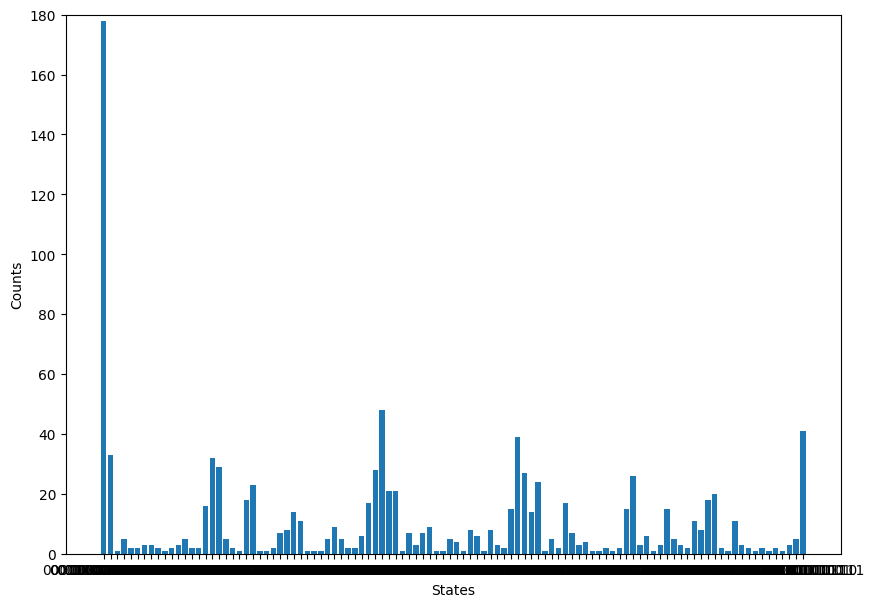

Estimated Period r: 128


In [15]:
# Execute the circuit
job = backend.run(qc, shots=shots)
job_monitor(job)
result = job.result()
counts = result.get_counts()
print(counts)
# visualize
plot_histogram(counts)


# Example: Simulating Quantum Circuit (Replace with actual QFT-inv results)
num_qubits = 7  # QFT register size

# Find period r
period_r = find_period_from_qiskit_results(result, qc,14)
print("Estimated Period r:", period_r)
#clean up
del q, c, qc
del result
del job


Footnotes

[1] This section is based on [10], [14], and [16].

[2] https://research.ibm.com/blog/factor-15-shors-algorithm

[3] Jiˇrí Tomˇcala, "On the Various Ways of Quantum Implementation
of the Modular Exponentiation Function for Shor’s
Factorization"

[4]https://en.wikipedia.org/wiki/Integer_factorization_records#Records_for_efforts_by_quantum_computers

In [18]:
# Compute x = a^(r/2) mod N
a=21
N=143
x = pow(a, period_r // 2, N)
print(f"x = {x}")

# Step 3: Compute gcd(x - 1, N) and gcd(x + 1, N)
gcd_1 = math.gcd(x - 1, N)
gcd_2 = math.gcd(x + 1, N)

print(f"gcd(x - 1, N) = {gcd_1}")
print(f"gcd(x + 1, N) = {gcd_2}")

# The factors of N are the non-trivial gcd values
factors = set([gcd_1, gcd_2])
factors.discard(1)  # Discard trivial factor
print("Factors of N:", factors)

x = 1
gcd(x - 1, N) = 143
gcd(x + 1, N) = 1
Factors of N: {143}
